In [1]:
import matplotlib.pyplot as plt

#Defining conventions for figure sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
import numpy as np

#call payoff function
def C(K,S):
    return (S-K+np.abs(S-K))/2.0

#put payoff function
def P(K,S):
    return (K-S+np.abs(K-S))/2.0
    
#Butterfly payoff function for equally spaced basis call functions
def B(S, K, h):
    return (C(K-h,S)-2*C(K,S)+C(K+h,S))/h

#Butterfly payoff function for unequally spaced basis call functions
def B_uneven(S, K1, K2, K3):
    h1 = K2 - K1
    h2 = K3 - K2
    a = 1/h1
    b = (h1 + h2)/(h1*h2)
    c = 1/h2
    return a*C(K1,S)-b*C(K2,S)+c*C(K3,S)

#computes the appropriate Butterfly coefficients for unequally spaced basis call functions
def B_coefs(K1, K2, K3):
    h1 = K2 - K1
    h2 = K3 - K2
    a = 1/h1
    b = (h1 + h2)/(h1*h2)
    c = 1/h2
    return a, b, c

In [3]:
from BS_data import black_scholes
import pandas as pd
import tensorflow_probability as tfp
import tensorflow as tf

#Generating Black-Scholes training and test data

K_min = 30
K_max = 70
N_hat = 11
N_t = 11
T = 0.4
t_test = 0.2
S = 50
sigma = 0.22
r = 0.04

#Training data_frame

T_vec = np.linspace(0, T, N_t) 
K_vec = np.linspace(K_min,K_max,N_hat)

space = []
for t in T_vec:
    for K in K_vec:
        space.append([t, K])
data_frame = pd.DataFrame(space,columns=['T', 'K'])

price = []
for index, row in data_frame.iterrows():
    price.append(black_scholes(S, row['K'], row['T'], r, sigma))
data_frame['price'] = price


#Test data_frame_prime

#choose shape of test data (price curve or surface)
one_D_fig = False #True for curve, False for surface
if(one_D_fig):
    N_prime = 81
    T_prime = [0.2]
else:
    N_prime = 21
    T_prime = np.linspace(0, T, N_prime)
K_prime = np.linspace(K_min,K_max,N_prime)

space_prime = []
for t in T_prime:
    for K in K_prime:
        space_prime.append([t, K])
data_frame_prime = pd.DataFrame(space_prime,columns=['T', 'K'])

price_prime = []
for index, row in data_frame_prime.iterrows():
    price_prime.append(black_scholes(S, row['K'], row['T'], r, sigma))
data_frame_prime['price'] = price_prime
    
print(data_frame)
print(data_frame_prime)

       T     K      price
0    0.0  30.0  20.000000
1    0.0  34.0  16.000000
2    0.0  38.0  12.000000
3    0.0  42.0   8.000000
4    0.0  46.0   4.000000
..   ...   ...        ...
116  0.4  54.0   1.558612
117  0.4  58.0   0.677369
118  0.4  62.0   0.262649
119  0.4  66.0   0.092058
120  0.4  70.0   0.029560

[121 rows x 3 columns]
       T     K      price
0    0.0  30.0  20.000000
1    0.0  32.0  18.000000
2    0.0  34.0  16.000000
3    0.0  36.0  14.000000
4    0.0  38.0  12.000000
..   ...   ...        ...
436  0.4  62.0   0.262649
437  0.4  64.0   0.157338
438  0.4  66.0   0.092058
439  0.4  68.0   0.052697
440  0.4  70.0   0.029560

[441 rows x 3 columns]


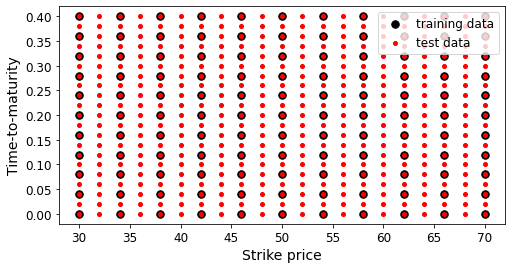

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.scatter(data_frame['K'], data_frame['T'], color = 'black', s = 56, label = 'training data')
plt.scatter(data_frame_prime['K'], data_frame_prime['T'], color = 'red', s = 16, label = 'test data')
plt.xlabel("Strike price")
plt.ylabel("Time-to-maturity")
plt.legend(loc = 'upper right')
plt.show()

In [5]:
### GP model + training

import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from tensorflow_probability.python.math.psd_kernels.internal import util
import custom_kernels

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

#here we define the discretised stock price space to compute our integrals and our payoff functions
omega = np.linspace(30,70,100)

#trainable variables
amplitude = 1.0
l1 = 1.0
amplitude = tfp.util.TransformedVariable(amplitude, tfb.Exp(), dtype=tf.float64, name='amplitude')
observation_noise_variance = tfp.util.TransformedVariable(1.99e-4, tfb.Exp(), dtype=tf.float64, name='observation_noise_variance')
length_scale = tfp.util.TransformedVariable(l1, tfb.Exp(), dtype=tf.float64, name='length_scale')

#choose either the 1D kernel (for only payoff function inputs) or the 2D kernel (for payoff fct + time-to-maturity inputs)
one_D_kernel = False
if(one_D_kernel):
    kernel = custom_kernels.integral_1D_kernel_custom(omega = omega, amplitude = amplitude)
else:
    kernel = custom_kernels.integral_2D_kernel_custom(omega = omega, amplitude = amplitude, length_scale = length_scale)

training_points = []
for i in range(len(data_frame['K'])):
    training_points.append(C(data_frame['K'][i], omega)) #payoff fct values at the omega points
observed_values = data_frame['price']

#In the 2D case we concatenate the vector of the payoff points with the time associated with that payoff
#the last element of the vector is thus the time component
#this is necessary since tf doesn't allow non-pythagorian tensors
if(not(one_D_kernel)):
    training_points = np.c_[training_points, data_frame['T']]
    
#define the GP
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=training_points,
    mean_fn=None,
    observation_noise_variance= observation_noise_variance)

#Train the model
optimizer = tf.optimizers.Adam(learning_rate = 0.1)

@tf.function
def optimize():
    with tf.GradientTape() as tape:
        loss = -gp.log_prob(observed_values)
    var_to_be_trained = gp.trainable_variables
    grads = tape.gradient(loss, var_to_be_trained)
    optimizer.apply_gradients(zip(grads, var_to_be_trained))
    return loss

# training
for i in range(500):
    neg_log_likelihood = optimize()

    if i % 100 == 0:
        print("Step {}: NLL = {}".format(i, neg_log_likelihood))
print("Final NLL = {}".format(neg_log_likelihood))


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Step 0: NLL = -11.211596368650362
Step 100: NLL = -79.05729297636566
Step 200: NLL = -79.26911802258087
Step 300: NLL = -79.26912248187173
Step 400: NLL = -79.26912248180858
Final NLL = -79.26912248178112


In [6]:
#Final hyperparameter values

print('amplitude: ', amplitude.numpy())
print('length scale: ', length_scale.numpy())
print('sigma_epsilon: ', observation_noise_variance.numpy())

amplitude:  0.048647124867775685
length scale:  0.6629721056902719
sigma_epsilon:  0.0025102706166387862


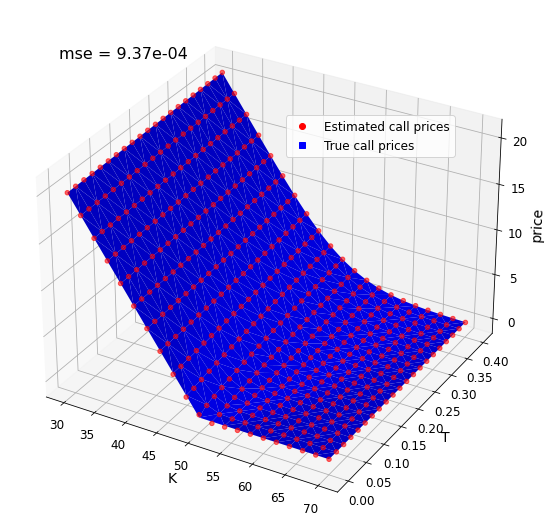

In [8]:
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D

#Test data
test_x = []
for i in range(len(data_frame_prime['K'])):
    test_x.append(C(data_frame_prime['K'][i], omega))
test_y = data_frame_prime['price']
if(not(one_D_kernel)):
    test_x = np.c_[test_x, data_frame_prime['T']]

#gprm defines the posterior distribution
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=test_x,
    mean_fn=None,
    observation_index_points=training_points,
    observations=observed_values,
    observation_noise_variance= observation_noise_variance)

m_star = np.array(gprm.mean()) #posterior mean
std_star = np.array(gprm.stddev()) #posterior std deviation
cov_star = gprm.covariance() #posterior covariance matrix

mse = mean_squared_error(m_star, test_y) #mse between estimated price and true price


#plot the price estimates for the test data in the 1D (price curve) or 2D (price surface) case
if(one_D_fig):
    x_axis = data_frame_prime['K']

    # Plot the call price
    plt.figure(figsize=(12, 4))
    plt.plot(x_axis, test_y, alpha = 0.8, color = 'b', linewidth = 3.0, label='true prices')
    plt.scatter(x_axis, m_star, c='r', alpha=1, linewidth = 0.75, label='estimated prices')
    plt.plot(x_axis, m_star - 1.96*std_star, c='darkorange', alpha=1, linestyle='dashed', label='95% confidence interval')
    plt.plot(x_axis, m_star + 1.96*std_star, c='darkorange', alpha=1, linestyle='dashed')

    leg = plt.legend(loc='upper right')
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.xlabel("Strike price")
    plt.ylabel("Call price")
    plt.title(r'$T = 0.2, \quad MSE = $' + str("{:.3E}".format(mse)))
    plt.show()
else:
    import matplotlib as mpl
    #select this to keep the 3D figure fixed
    %matplotlib inline
    
    #select this to rotate 3D figure with mouse pointer
#     %matplotlib notebook

    fig = plt.figure(figsize=(6,6))
    fig.subplots_adjust(top=1, bottom=-0.2, left=-0.3, right=1.3)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(data_frame_prime['K'], data_frame_prime['T'], data_frame_prime['price'], color = 'b', alpha = 1, label = 'true BS prices')
    ax.scatter(data_frame_prime['K'], data_frame_prime['T'], m_star, alpha = 0.6, color = 'r', label = 'estimated prices')
    ax.set_xlabel('K')
    ax.set_ylabel('T')
    ax.set_zlabel('price')
    fake2Dline = [mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o'),\
                  mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 's')]
    ax.legend(fake2Dline, ['Estimated call prices', 'True call prices'], numpoints = 1, bbox_to_anchor=[0.7, 0.75], loc='center')
    ax.text2D(0.1, 0.9, "mse = "+str('{:.2e}'.format(mse)), transform=ax.transAxes, fontsize = 16)
    plt.show()




is sample convex:  False
is projection convex:  True


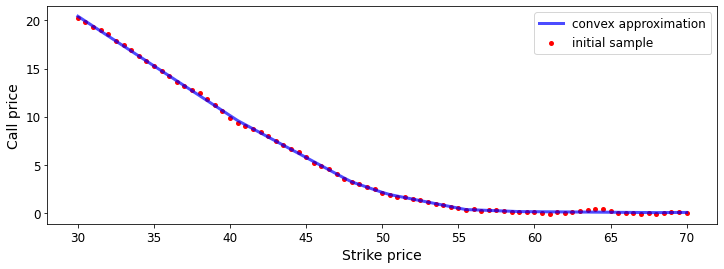

In [35]:
#This cell applies the strike convexity condition to a sampled price curve
#only run if one_D_fig = True

def check_convex(y):
    for i in range(len(y)-2):
        if((y[i]-2*y[i+1]+y[i+2]) < 0):
            return False
    return True

#jacobian of conditions
def cons_J(x):
    y = []
    for i in range(len(x)-2):
        temp = np.zeros(len(x))
        temp[i] = 1
        temp[i+1] = -2
        temp[i+2] = 1
        y.append(temp)
    return y

from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

if(one_D_fig): 
    x0 = np.array(gprm.sample()) #non_convex sample
    
    #Euclidean distance fct
    def func(x):
        return np.linalg.norm(x-x0)**2
    
    linear_constraint = LinearConstraint(cons_J(x0), np.zeros(len(x0)-2), np.inf*np.ones(len(x0)-2)) #convexity constraint
    res = minimize(func, x0, method='trust-constr', constraints=linear_constraint, options={'verbose': 0}) #minimising fct

    print('is sample convex: ', check_convex(x0))
    print('is projection convex: ', check_convex(res.x))
    
    #plot non-convex sample and convex approximation
    plt.figure(figsize=(12, 4))
    plt.scatter(K_prime, x0, alpha = 1.0, color='r', linewidth = 2.0, marker = '.', label = 'initial sample')
    plt.plot(K_prime, res.x, alpha = 0.7, color='b', linewidth = 3.0, label = 'convex approximation')
    plt.ylabel("Call price")
    plt.xlabel("Strike price")
    plt.legend()
    plt.show()

Number of points that break NA conditions before projection:  (53, 24)
Number of points that break NA conditions after projection:  (0, 0)
MSE:  0.0008392393740768858


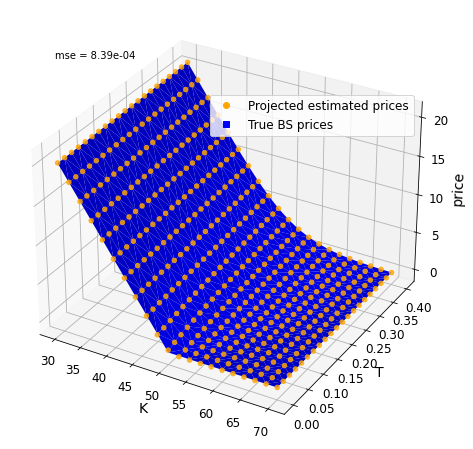

In [9]:
#This cell applies the strike convexity condition and 
#the time-to-maturity monotone increasing condition to a sampled price surface
#only run if one_D_fig = False

#This cell can take a couple minutes to run

#The sample to be optimised must be of the form:
#[P(T1,K1), P(T1,K2), P(T1,K3), P(T2,K1), P(T2,K2), P(T2,K3)]
#where here N_T_prime = 2 and N_K_prime = 3
N_T_prime = N_prime
N_K_prime = N_prime

#checks whether NA conditions are obeyed and counts the number of points that break them
def check_NA(x):
    non_convex_count = 0
    non_monotone_count = 0
    #convexity conditions
    for i in range(N_T_prime):
        for j in range(N_K_prime-2):
            if((x[N_K_prime*i+j] - 2*x[N_K_prime*i+j+1] + x[N_K_prime*i+j+2]) < 0):
                non_convex_count += 1
    #monotonicity conditions
    for i in range((N_T_prime-1)*N_K_prime):
        if((x[N_K_prime+i] - x[i]) < 0):
            non_monotone_count += 1
    
    return non_convex_count, non_monotone_count

#Jacobian of conditions
def cons_J2(x):
    y = []
    #convexity conditions
    for i in range(N_T_prime):
        for j in range(N_K_prime-2):
            temp = np.zeros(len(x))
            temp[N_K_prime*i+j] = 1
            temp[N_K_prime*i+j+1] = -2
            temp[N_K_prime*i+j+2] = 1
            y.append(temp)
    #monotonicity conditions
    for i in range((N_T_prime-1)*N_K_prime):
        temp = np.zeros(len(x))
        temp[N_K_prime+i] = 1
        temp[i] = -1
        y.append(temp)
    return y


from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

if(not(one_D_fig)):
    #non-convex, non-monotone sample
    x0 = np.array(gprm.mean())

    #Euclidean distance function
    def func(x):
        return np.linalg.norm(x-x0)**2

    n_constraints = N_T_prime*(N_K_prime-2)+(N_T_prime-1)*N_K_prime #number of constraints
    linear_constraint = LinearConstraint(cons_J2(x0), np.zeros(n_constraints), np.inf*np.ones(n_constraints))

    res = minimize(func, x0, method='trust-constr', constraints=linear_constraint, options={'verbose': 0}) #minimising fct

    mse = mean_squared_error(res.x, data_frame_prime['price']) #mse between projected price surface and true prices

    print('Number of points that break NA conditions before projection: ', check_NA(x0))
    print('Number of points that break NA conditions after projection: ', check_NA(res.x))
    print('MSE: ', mean_squared_error(res.x, data_frame_prime['price']))

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_frame_prime['K'], data_frame_prime['T'], res.x, alpha = 0.8, color = 'orange')
    ax.plot_trisurf(data_frame_prime['K'], data_frame_prime['T'], data_frame_prime['price'], alpha = 1.0, color = 'b')
    ax.set_xlabel('K')
    ax.set_ylabel('T')
    ax.set_zlabel('price')

    fake2Dline = [mpl.lines.Line2D([0],[0], linestyle="none", c='orange', marker = 'o'),\
                  mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 's')]
    ax.legend(fake2Dline, ['Projected estimated prices', 'True BS prices'], numpoints = 1, bbox_to_anchor=[0.7, 0.75], loc='center')
    ax.text2D(0.11, 0.88, "mse = "+str('{:.2e}'.format(mse)), transform=ax.transAxes)

    plt.show()